### 10 Myths of A/B Testing: How to Avoid Common Misconceptions in Statistical Analysis
This notebook contains the code for the publication '10 Myths of A/B Testing: How to Avoid Common Misconceptions in Statistical Analysis'.

For some myths we will use simulations. When checking the correctness of a statistical test, we will proceed as follows:
1. Fix the significance level at $\alpha = 0.05$.


2. Calculate the p-value 1,000 times using our statistical test model. We will utilize the fact that, under the null hypothesis, the p-value should be uniformly distributed, therefore, if our statistical test is correct, the proportion of cases where the p-value < $\alpha$  should be approximately  $\alpha$ .


3. We can visually inspect uniformity by creating a QQ plot comparing the uniform distribution to the actual p-value data.


4. Additionally, we can calculate a confidence interval for the Type I error rate and check that $\alpha$ lies in this interval. 

In [76]:
import numpy as np
import scipy.stats as stats
from tqdm import tqdm as tqdm
import random
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import IPython


# Myth 1: Using Raw Event Data for A/B Tests

Let's fix $n$ - the number of users in the test and control groups. We will generate data for each user $i$ in 3 stages. 

Stage 1: Determine the number of events $k_i$ using a Poisson distribution. Let's say we get $k_i = 3$.

Stage 2: Generate a vector of size $k_i$ with the same metric value using an exponential distribution. For this example, let's assume the generated value is 400, so the vector becomes (400, 400, 400).

Stage 3: Apply a noise factor to each value in the vector by randomly selecting values from the list [0.8, 0.9, 1, 1.1, 1.2]. The noise factors specified in this example are 1.1, 0.8, and 0.9. Therefore, the final vector becomes (440, 320, 360).


In [5]:
#Let's fix the significance level at 0.05 for all simulations below.

alpha = 0.05

In [6]:
#This function generates data for the test group and the control group without aggregation (control_event, test_event) and with per-user aggregation (control_user, test_user).


def group_sample_gen(mu_exp=500, mu_pois=3, n=10000):
    noise_factors = [0.8, 0.9, 1, 1.1, 1.2]
    test_event = []
    control_event = []
    test_user = []
    control_user = []
    for i in range(n):
        k_test = np.random.poisson(lam=mu_pois)
        noise_test = [random.choice(noise_factors) for _ in range(k_test)]
        test_temp = [np.random.exponential(mu_exp)] * k_test
        test_event = test_event + [a * b for a, b in zip(noise_test, test_temp)]
        test_user = test_user + [sum([a * b for a, b in zip(noise_test, test_temp)])]
        k_control = np.random.poisson(lam=mu_pois)
        noise_control = [random.choice(noise_factors) for _ in range(k_control)]
        control_temp = [np.random.exponential(mu_exp)] * k_control
        control_event = control_event + [a * b for a, b in zip(noise_control, control_temp)]
        control_user = control_user + [sum([a * b for a, b in zip(noise_control, control_temp)])]
    return test_event, control_event, test_user, control_user 

In [7]:
#Calculate p-value 1,000 times for data without aggregation (p_value_event) and for data with per-user aggregation (p_value_user).

pvalue_tt_event_myth_1 = []
pvalue_tt_user_myth_1 = []
for i in tqdm(range(1000)):
    test_event, control_event, test_user, control_user  = group_sample_gen()
    _, p_value_event = stats.ttest_ind(test_event, control_event)
    _, p_value_user = stats.ttest_ind(test_user, control_user)
    pvalue_tt_event_myth_1.append(p_value_event)
    pvalue_tt_user_myth_1.append(p_value_user)

100%|██████████| 1000/1000 [17:39<00:00,  1.06s/it]


In [8]:
#This function calculates the confidence interval for the proportion of successes in a series of Bernoulli trials.

def proportion_ci(pvalue_vector, alpha=0.05):
    pvalue_vector = np.asarray(pvalue_vector).flatten()
    n = len(pvalue_vector)
    count = np.sum(pvalue_vector < alpha)
    p = count / n
    left_bound = p - np.sqrt(p * (1 - p) / n) * np.abs(stats.norm.ppf(alpha))
    right_bound = p + np.sqrt(p * (1 - p) / n) * np.abs(stats.norm.ppf(alpha))
    return p, left_bound, right_bound

In [86]:
#In this chart, we compare the distribution of p-values with the uniform distribution. The left part displays a histogram of the p-values. The right part shows a QQ-plot, where the quantiles of the p-value distribution are compared with the corresponding quantiles of the uniform distribution. The distribution of p-values is similar to the uniform distribution if all points are close to the diagonal.
def plot_comparison_with_uniform(p_value_vector, title, color = 'skyblue'):
    p, left_boundary, right_boundary = proportion_ci(p_value_vector)
    print(f"Type I Error: {round(p, 4)},\nCI for p-value: [{round(left_boundary, 4)}, {round(right_boundary, 4)}]")


    fig1, ax1 = plt.subplots(1, 2, figsize=(12, 5))

    # Plotting a histogram for raw event data
    ax1[0].hist(p_value_vector, bins=30, edgecolor='black', alpha=0.7, color=color)
    ax1[0].set_title(f'Type I Error: {round(np.sum(np.array(p_value_vector) < 0.05) / len(p_value_vector), 3)}')
    ax1[0].set_xlabel('P-value')
    ax1[0].set_ylabel('Frequency')

    # Plotting a QQ-plot for raw event data
    stats.probplot(p_value_vector, dist=stats.uniform, plot=ax1[1])
    ax1[1].get_lines()[1].set_linestyle('--')
    ax1[1].set_title(f'{title}')

    plt.tight_layout()
    plt.show()

Type I Error: 0.319,
CI for p-value: [0.2948, 0.3432]


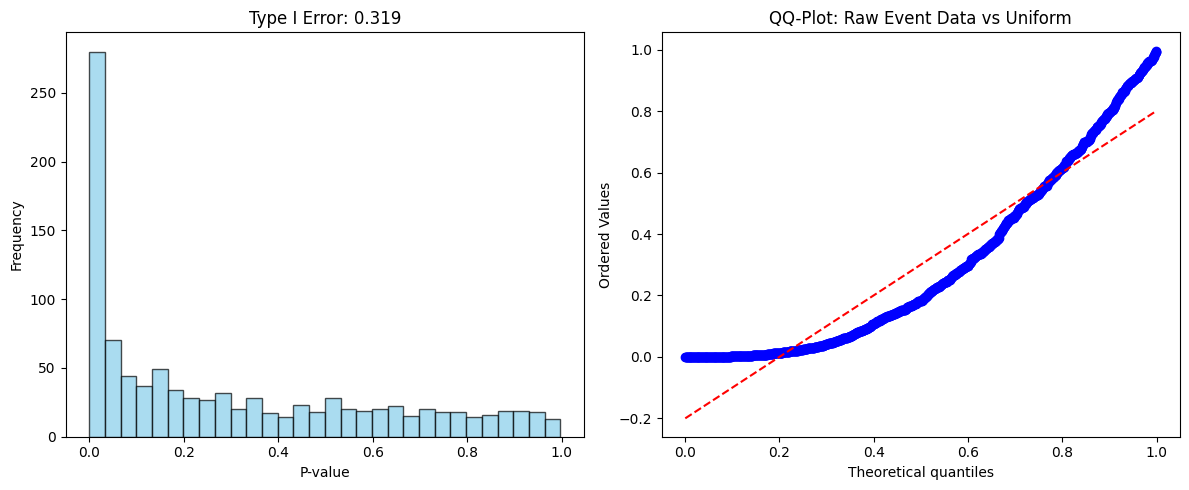

In [87]:
p_value_vector = pvalue_tt_event_myth_1
plot_comparison_with_uniform(p_value_vector, 'QQ-Plot: Raw Event Data vs Uniform')

Type I Error: 0.045,
CI for p-value: [0.0342, 0.0558]


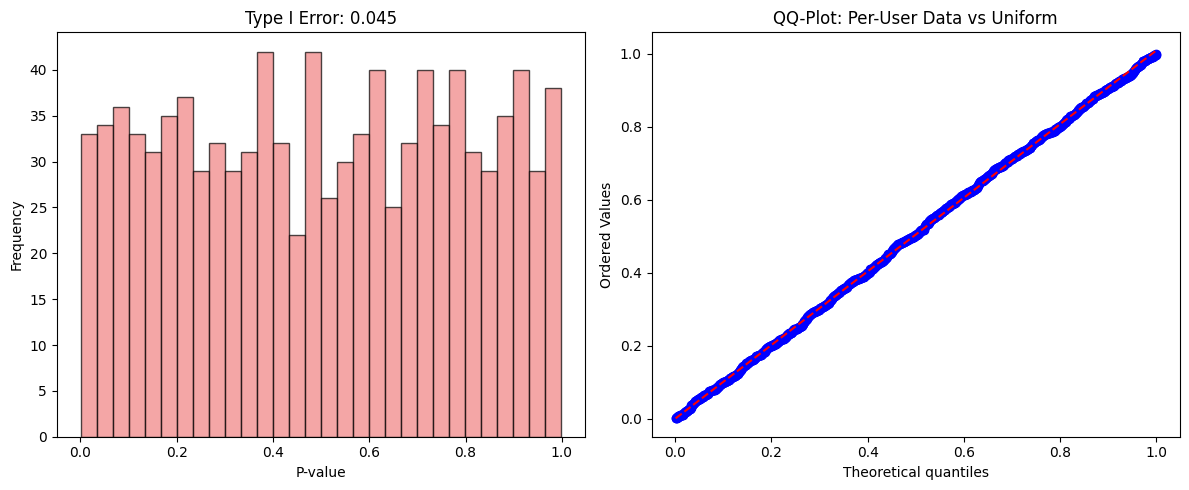

In [88]:
p_value_vector = pvalue_tt_user_myth_1
plot_comparison_with_uniform(p_value_vector, 'QQ-Plot: Per-User Data vs Uniform', 'lightcoral')

# Myth 2: User-Level Aggregation Works for All Metrics

What shall we do with ratio metrics?

# Myth 3: T-Test Requires Normally Distributed Input Data


In [14]:
#This function generates a vector of size num_iterations, where each element is obtained as follows: We find the mean from sample_size random variables of a given distribution. Then, for num_iterations such means, we compute the sample mean and standard deviation, and subsequently normalize each original mean by these values.

# AS distribution_func we will use np.random.uniform, np.random.normal, np.random.exponential, np.random.binomial

def normalized_means(distribution_func, params, sample_size=1000, num_iterations=10000):  
    means = []
    for i in range(num_iterations):
        random_sample = distribution_func(*params, sample_size)
        mean = np.mean(random_sample)
        means.append(mean)
    means_array = np.array(means)
    mu = np.mean(means_array)
    std = np.std(means_array, ddof=1)
    normalized_means_array = (means_array - mu) / std
    return normalized_means_array


In [15]:
#A function for plotting graphs.

def plot_graph(distribution_func, params, sample_size=1000, num_iterations=10000):
    norm_0_1 = np.random.normal(0, 1, num_iterations)
    x_n = normalized_means(distribution_func, params, sample_size, num_iterations)
    sns.kdeplot(norm_0_1, color = 'red', label='normal')
    if distribution_func == np.random.normal:
        sns.kdeplot(x_n, fill = True, label='normal')  
        plt.xlim(-6, 6)
        plt.title(f'The mean for {sample_size} random variables: Normal vs Normal')
        plt.legend()
        plt.show()
    elif distribution_func == np.random.uniform:
        sns.kdeplot(x_n, fill = True, label='uniform')  
        plt.xlim(-6, 6)
        plt.title(f'The mean for {sample_size} random variables: Uniform vs Normal')
        plt.legend()
        plt.show()
    elif distribution_func == np.random.exponential:
        sns.kdeplot(x_n, fill = True, label='exponential')  
        plt.xlim(-6, 6)
        plt.title(f'The mean for {sample_size} random variables: Exponential vs Normal')
        plt.legend()
        plt.show()
    elif distribution_func == np.random.binomial:
        sns.kdeplot(x_n, fill = True, label='binomial')  
        plt.xlim(-6, 6)
        plt.title(f'The mean for {sample_size} random variables: Binomial vs Normal')
        plt.legend()
        plt.show()
    else:
        return None


### Normalized Mean of Uniform Random Variables


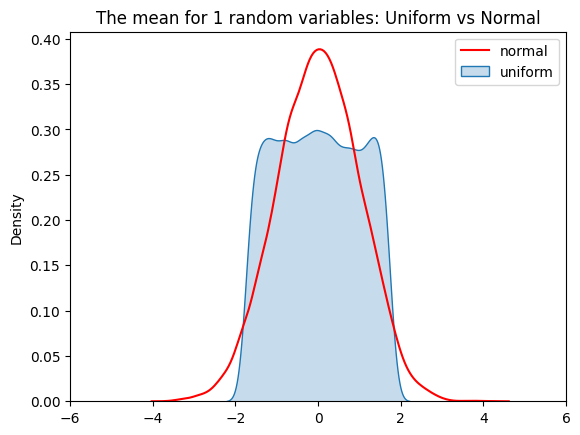

In [16]:
#Setting Distribution Parameters
left = -1
right = 1
params = (left, right)
distribution_func = np.random.uniform

#Change the sample_size to see how quickly the means converge to normal.
sample_size = 1
num_iterations = 10000

plot_graph(distribution_func, params, sample_size, num_iterations)

### Normalized Mean of Normal Random Variables


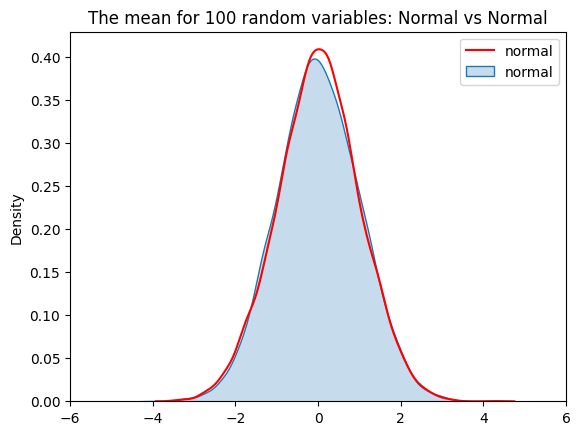

In [18]:
#Setting Distribution Parameters
mu = 10
std = 5
params = (mu, std)
distribution_func = np.random.normal

#Change the sample_size to see how quickly the means converge to normal.
sample_size = 100
num_iterations = 10000

plot_graph(distribution_func, params, sample_size, num_iterations)

### Normalized Mean of Binomial Random Variables

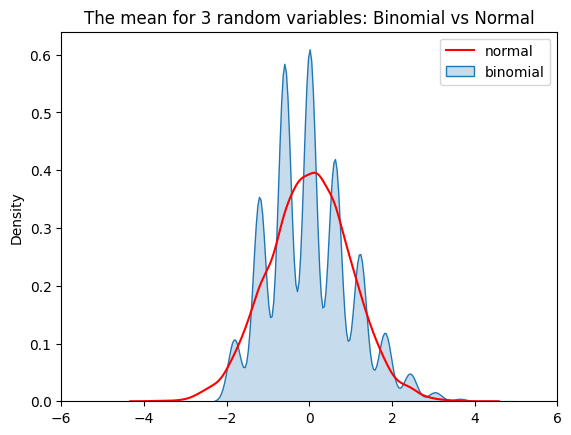

In [19]:
#Setting Distribution Parameters
num = 10
p = 0.1
params = (num, p)
distribution_func = np.random.binomial
#Change the sample_size to see how quickly the means converge to normal.
sample_size = 3
num_iterations = 10000

plot_graph(distribution_func, params, sample_size, num_iterations)

### Normalized Mean of Exponential Random Variables


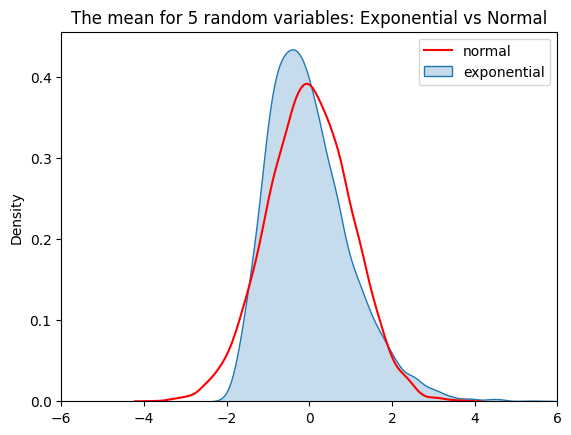

In [20]:
#Setting Distribution Parameters
mu = 1000
params = (mu, )
distribution_func = np.random.exponential

#Change the sample_size to see how quickly the means converge to normal.
sample_size = 5
num_iterations = 10000

plot_graph(distribution_func, params, sample_size, num_iterations)

## Myth 4: Simply Removing Outliers Solves the (any) Problem

Let's generate a test and control group from the same distribution and then remove outliers using different methods.

In [100]:
def remove_outliers(distribution_func, params, cap, sample_size = 10000, num_iterations = 1000, quantile = 0.99):
    
    pvalue_tt_separatеly = []
    pvalue_tt_together = []
    pvalue_tt_cap = []
    
    for i in tqdm(range(num_iterations)):
        control = distribution_func(*params, sample_size)
        test = distribution_func(*params, sample_size)
        outlier_control_filter = np.quantile(control, quantile)
        outlier_test_filter = np.quantile(test, quantile)
        outlier_filter = np.quantile(np.concatenate([control, test]), quantile)
        _, pvalue_separatеly = stats.ttest_ind(test[test < outlier_test_filter], control[control < outlier_control_filter])
        _, pvalue_together = stats.ttest_ind(test[test < outlier_filter], control[control < outlier_filter])
        test_cap = test
        test_cap[test_cap > cap] = cap
        control_cap = control
        control_cap[control_cap > cap] = cap
        _, pvalue_cap = stats.ttest_ind(test_cap, control_cap)
        pvalue_tt_separatеly.append(pvalue_separatеly)
        pvalue_tt_together.append(pvalue_together)
        pvalue_tt_cap.append(pvalue_cap)
    return pvalue_tt_separatеly, pvalue_tt_together, pvalue_tt_cap

In [101]:
#Setting Distribution Parameters
distribution_func = np.random.exponential
mu = 1000
params = (mu, )

cap = 4700

sample_size = 10000
num_iterations = 10000
quantile = 0.99

In [102]:
pvalue_tt_separatеly_myth_4, pvalue_tt_together_myth_4, pvalue_tt_cap_myth_4 = remove_outliers(distribution_func, params, cap, sample_size, num_iterations, quantile)

100%|██████████| 10000/10000 [00:16<00:00, 619.79it/s]


Type I Error: 0.0698,
CI for p-value: [0.0656, 0.074]


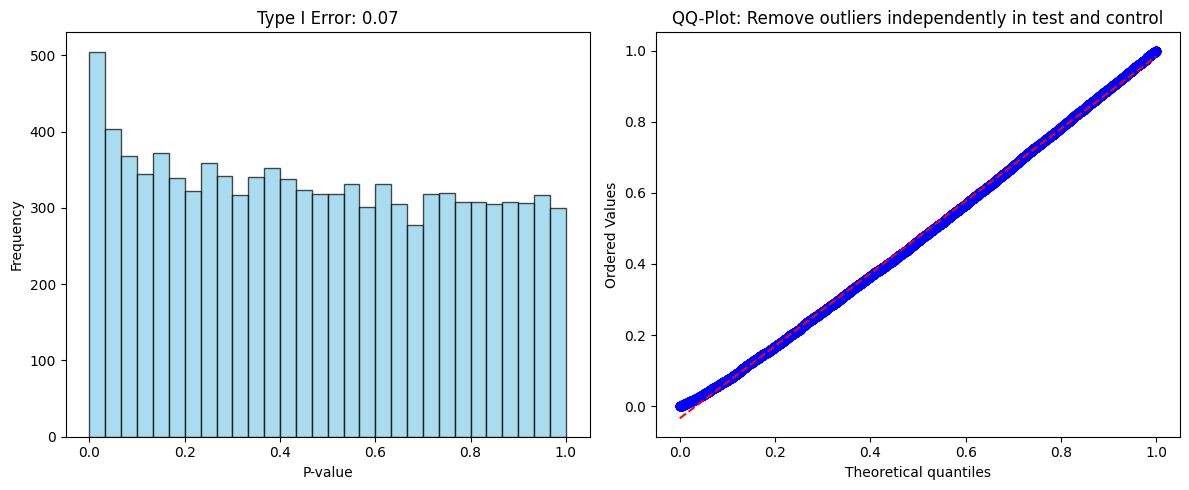

In [103]:
p_value_vector = pvalue_tt_separatеly_myth_4
plot_comparison_with_uniform(p_value_vector, 'QQ-Plot: Remove outliers independently in test and control')

Type I Error: 0.0527,
CI for p-value: [0.049, 0.0564]


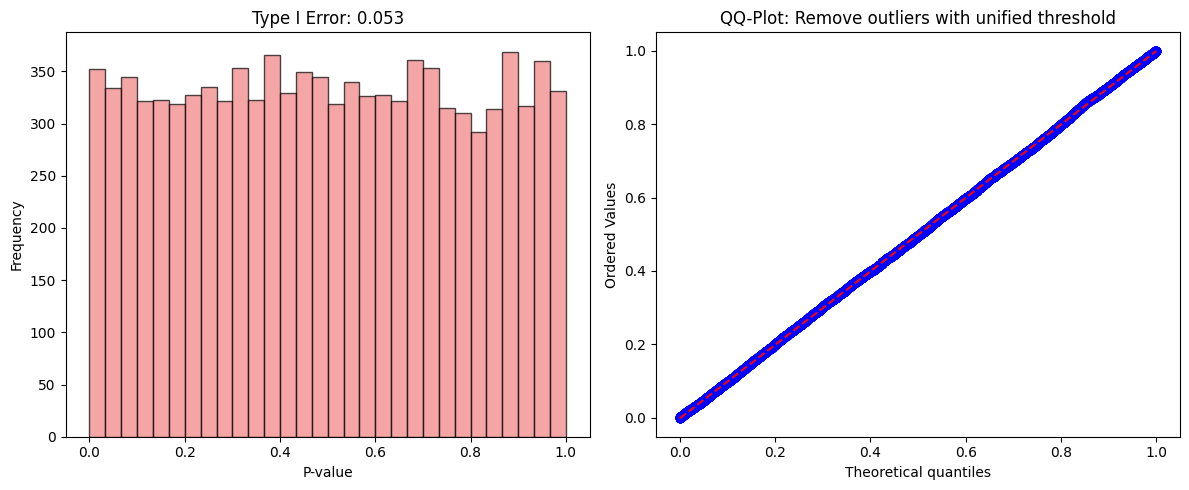

In [104]:
p_value_vector = pvalue_tt_together_myth_4
plot_comparison_with_uniform(p_value_vector, 'QQ-Plot: Remove outliers with unified threshold', 'lightcoral')

Type I Error: 0.0513,
CI for p-value: [0.0477, 0.0549]


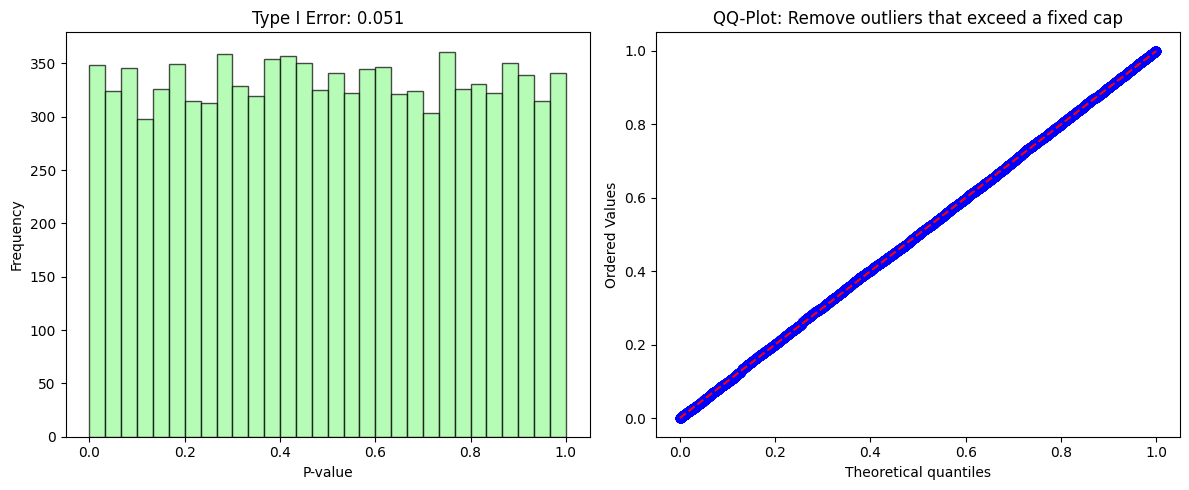

In [105]:
p_value_vector = pvalue_tt_cap_myth_4
plot_comparison_with_uniform(p_value_vector, 'QQ-Plot: Remove outliers that exceed a fixed cap', 'palegreen')

# Myth 5: Mann-Whitney Test Checks Mean Differences

Let's generate two normal distributions for the test and control groups with the same mean but different variances.  



In [53]:
samle_size = 10000
num_iterations = 10000

p_values_mw_myth_5 = []
p_values_tt_myth_5 = []
for _ in tqdm(range(num_iterations)):
    control = np.random.normal(0, 10, samle_size)  
    test = np.random.normal(0, 100, samle_size)
    p_values_mw_myth_5.append(stats.mannwhitneyu(test, control)[1])
    p_values_tt_myth_5.append(stats.ttest_ind(test, control)[1])

100%|██████████| 10000/10000 [01:26<00:00, 115.04it/s]


Type I Error: 0.0497,
CI for p-value: [0.0461, 0.0533]


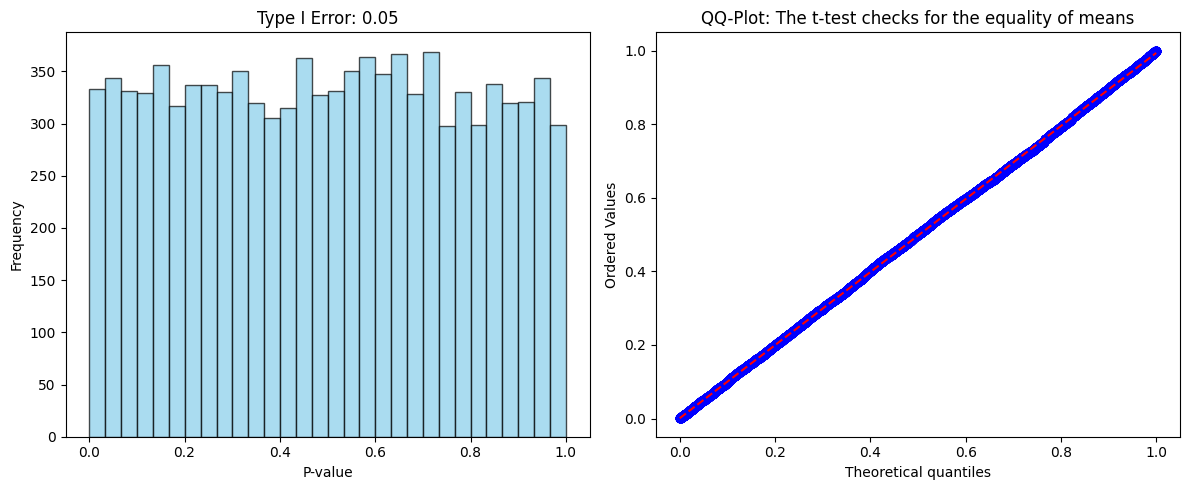

In [54]:
p_value_vector = p_values_tt_myth_5
plot_comparison_with_uniform(p_value_vector, 'The t-test checks for the equality of means')

Type I Error: 0.0959,
CI for p-value: [0.0911, 0.1007]


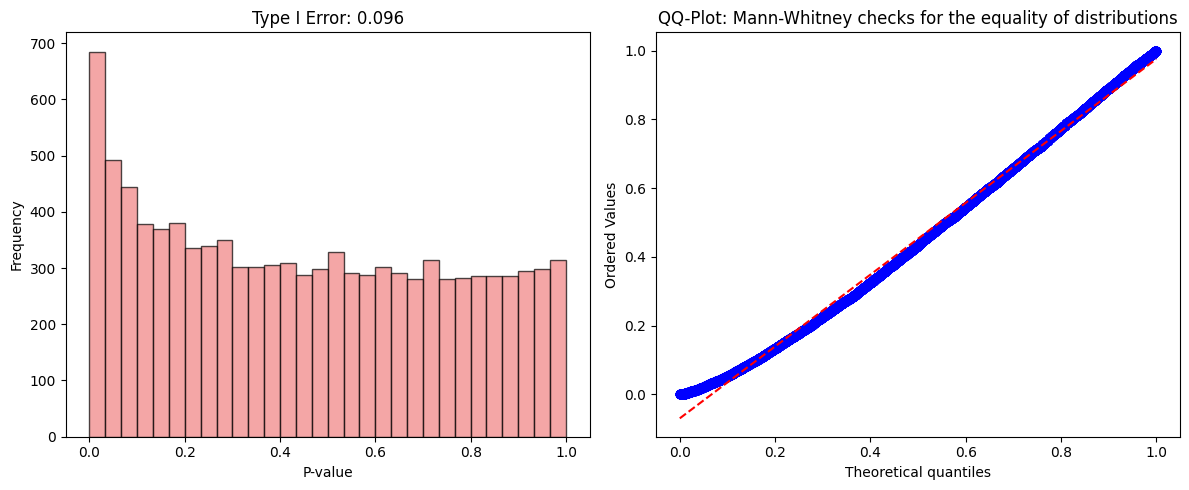

In [55]:
p_value_vector = p_values_mw_myth_5
plot_comparison_with_uniform(p_value_vector, 'Mann-Whitney checks for the equality of distributions', 'lightcoral')

Myth 8: The More Metrics, the Better


In [74]:
def get_metrics_sample(distribution_func, params, sample_size, num_metrics):
    df = pd.DataFrame()
    for i in range(num_metrics):
        df[f'metric_{i+1}'] = distribution_func(*params, 2*sample_size)
    vector_for_group = np.array(['test'] * sample_size + ['control'] * sample_size)
    np.random.shuffle(vector_for_group)
    df['group'] = vector_for_group
    return df

In [83]:
distribution_func = np.random.exponential
mu = 1000
params = (mu, ) 
num_metrics = 25
sample_size = 1000
num_iterations = 1000

list_of_pvalues = []
for _ in tqdm(range(num_iterations)):
    pvalues = []
    temp_df_metrics = get_metrics_sample(distribution_func, params, sample_size, num_metrics)
    
    df_test = temp_df_metrics[temp_df_metrics['group'] == 'test']
    df_control = temp_df_metrics[temp_df_metrics['group'] == 'control']
    
    for metric in (temp_df_metrics.columns[0:-1]):        
        pvalues.append(stats.ttest_ind(df_test[metric], df_control[metric])[1])  #obtain the p-value for each metric
    
    list_of_pvalues.append(pvalues)
    


100%|██████████| 1000/1000 [00:09<00:00, 104.35it/s]


In [85]:
fwer = [int((pvalues < alpha).sum() > 0) for pvalues in np.array(list_of_pvalues)] 
print(f'FWER (familywise error rate), the probability of rejection of at least one null hypothesis w/o real effect: {np.mean(fwer):0.3f}')


FWER (familywise error rate), the probability of rejection of at least one null hypothesis w/o real effect: 0.711


# Myth 9: Statistical Power Isn’t Critical


Many assume that 80% power is a standard benchmark but fail to evaluate the actual power of a given experiment.


In [56]:
def power(distribution_func, params, sample_size = 10000, num_iterations = 1000, effect = 0.01, alpha = 0.05):
    success_cnt = 0
    for i in range(num_iterations):
        control = distribution_func(*params, sample_size)
        test = distribution_func(*params, sample_size)*(1+effect)
        pvalue = stats.ttest_ind(test, control)[1]
        if pvalue < alpha:
            success_cnt += 1
    return success_cnt/num_iterations

In [57]:
mu = 1000
params = (mu, )
distribution_func = np.random.exponential

In [59]:
success_cnt_1 = []
success_cnt_5 = []
num_iterations = 1000
for size in tqdm(np.arange(100, 100000, 1000)):
    b_1 = power(distribution_func, params, size, num_iterations, 0.01, alpha)
    b_5 = power(distribution_func, params, size, num_iterations, 0.05, alpha)
    success_cnt_1.append(b_1)
    success_cnt_5.append(b_5)

100%|██████████| 100/100 [04:53<00:00,  2.94s/it]


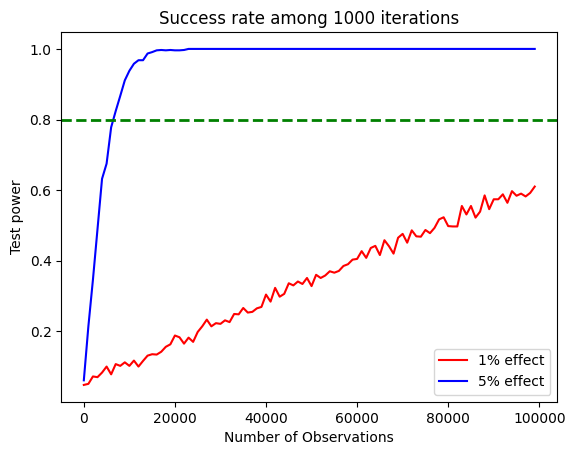

In [63]:
plt.plot(np.arange(0, 100000, 1000), success_cnt_1,  color='red', label='1% effect')
plt.plot(np.arange(0, 100000, 1000), success_cnt_5,  color='blue', label='5% effect')
plt.axhline(0.8, color='g', linestyle='dashed', linewidth=2)
plt.title(f"Success rate among {num_iterations} iterations")
plt.xlabel('Number of Observations')
plt.ylabel('Test power')
plt.legend()

## Myth 10: Stopping an Experiment as Soon as Results Look Significant


In [66]:
#This function iteratively goes through the test and control data and stops the comparison if the p-value from the examined segment of the data is less than the significance level.
def sequential_ttest(test, control, alpha = 0.05):
    p_values_vector = []
    time_points = []
    sample_size = min(len(test), len(control))
    for i in range(2, sample_size):     # Simulate data flow
        test_data_flow = test[:i]
        control_data_flow = control[:i]
        pvalue = stats.ttest_ind(test_data_flow, control_data_flow)[1] # With each new observation, we test the hypothesis
        if pvalue < alpha:
            return 1, pvalue
    return 0, pvalue

In [69]:
num_iterations = 1000
sample_size = 10000

#Setting Distribution Parameters
distribution_func = np.random.exponential
mu = 1000
params = (mu, )

p_values_classic = []
p_values_sequential = []
for _ in tqdm(range(num_iterations)):
    test = distribution_func(*params, sample_size)
    control = distribution_func(*params, sample_size)
    p_values_sequential.append(sequential_ttest(test,control)[1])
    p_values_classic.append(stats.ttest_ind(test,control,equal_var=False)[1])   

100%|██████████| 1000/1000 [17:57<00:00,  1.08s/it] 


Type I Error: 0.667,
CI for p-value: [0.6425, 0.6915]


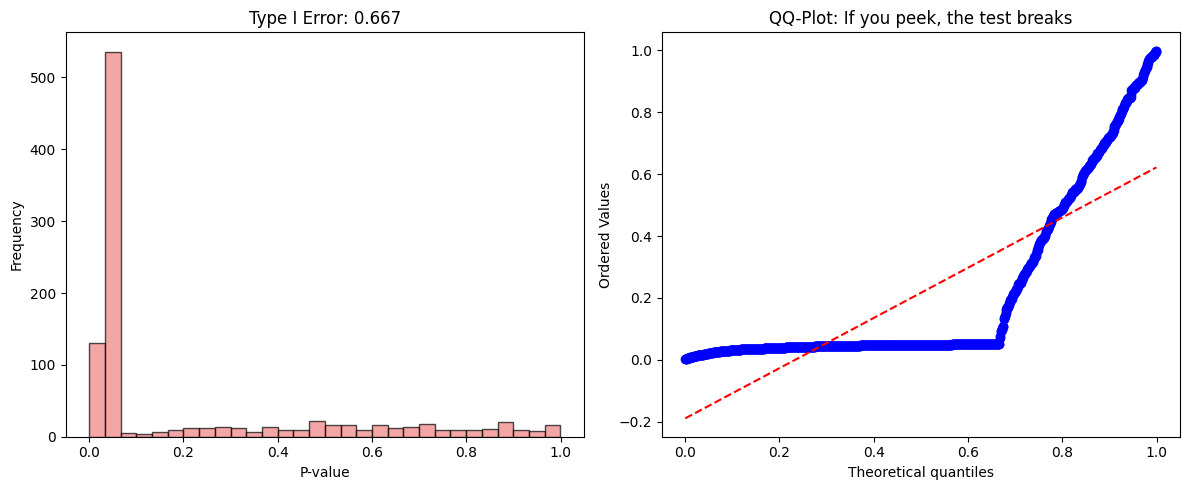

In [70]:
p_value_vector = p_values_sequential
plot_comparison_with_uniform(p_value_vector, 'If you peek, the test breaks', 'lightcoral')

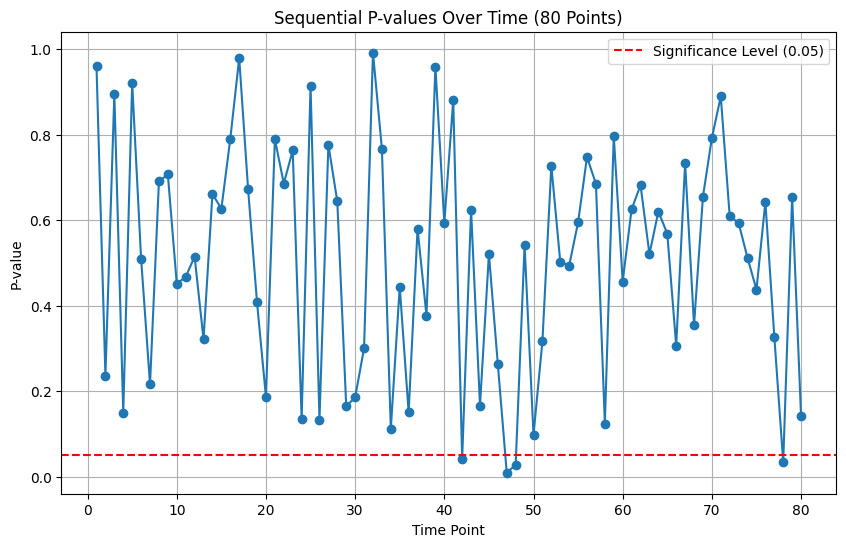

In [107]:
p_values_first_80 = p_values_classic[:80]

time_points_first_80 = list(range(1, len(p_values_first_80) + 1))

plt.figure(figsize=(10, 6))
plt.plot(time_points_first_80, p_values_first_80, marker='o', linestyle='-')
plt.title('Sequential P-values Over Time (80 Points)')
plt.xlabel('Time Point')
plt.ylabel('P-value')
plt.grid(True)

plt.axhline(y=alpha, color='r', linestyle='--', label=f'Significance Level ({alpha})')

plt.legend()
plt.show()